<a href="https://colab.research.google.com/github/yashika-git/Deep_Learning/blob/main/RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Training a simple RNN

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

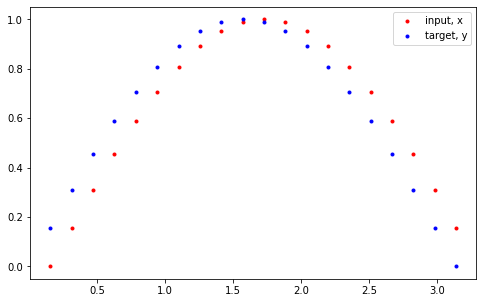

In [2]:
plt.figure(figsize=(8,5))

# how many time steps/data pts are in one batch of data
seq_length = 20

# generate evenly spaced data points using sine function
time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data.resize((seq_length + 1, 1)) # size becomes (seq_length+1, 1), adds an input_size dimension

x = data[:-1] # all but the last piece of data
y = data[1:] # all but the first

# display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

In [3]:
# Defining RNN
# RNN layer parameters are:
#input_size - the size of the input
#hidden_dim - the number of features in the RNN output and in the hidden state
#n_layers - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a stacked RNN
#batch_first - whether or not the input/output of the RNN will have the batch_size as the first dimension (batch_size, seq_length, hidden_dim)

In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim

        # defining an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # changing shape of output to (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        #final output
        output = self.fc(r_out)
        
        return output, hidden

In [5]:
# Checking the input and output dimensions in order to verify if model is working as expected
# test that dimensions are as expected
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)

# generate evenly spaced, test data pts
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))

test_input = torch.Tensor(data).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None) #initial hidden state is None
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 20, 1])
Output size:  torch.Size([20, 1])
Hidden state size:  torch.Size([2, 1, 10])


In [6]:
#input size dims indicate : batch_size, sequence_length, inp_num_features
#output size dims indicate : batch_size*seq_length, output_length
#hidden state dims indicate : number_of_layers_specified, batch_size, hidden_dim 

In [7]:
#Training the RNN

In [8]:
input_size = 1
output_size = 1
hidden_dim = 32
n_layers = 1

#initializing
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)


RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [9]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

In [29]:
# training the RNN

def train(rnn, n_steps, print_every):

  #initialize the hidden state
  hidden = None

  for batch_i, step in enumerate(range(n_steps)):
    # defining the training data 
    time_steps = np.linspace(step*np.pi, (step+1)*np.pi, seq_length+1)
    data = np.sin(time_steps)
    data.resize((seq_length+1, 1))

    x = data[:-1]
    y = data[1:]

    # convert data into tensors
    x_tensor = torch.Tensor(x).unsqueeze(0) #to make input 3 dimensional
    y_tensor = torch.Tensor(y)

    # outputs from the rnn
    prediction, hidden = rnn(x_tensor, hidden)
    # make a new variable for hidden and detach the hidden state from its history
    # this way, we don't backpropagate through the entire history
    hidden = hidden.data
    loss = criterion(prediction, y_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_i%print_every == 0:        
      print('Loss: ', loss.item())
      plt.plot(time_steps[1:], y, 'r.') # plotting the input
      plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
      plt.show()
    
  return rnn




Loss:  0.0028386753983795643


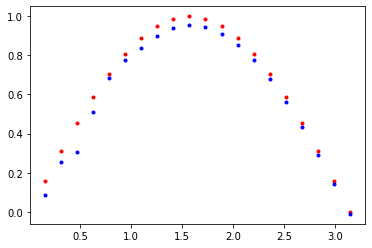

Loss:  0.0003286873979959637


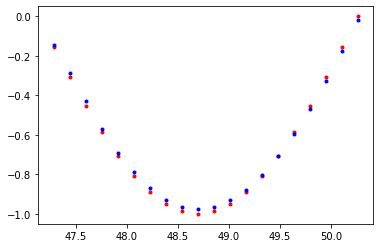

Loss:  9.813623182708398e-05


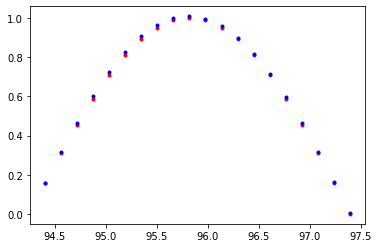

Loss:  1.3461429261951707e-05


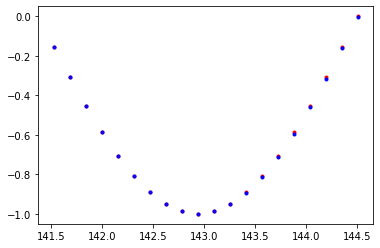

Loss:  5.955535925750155e-06


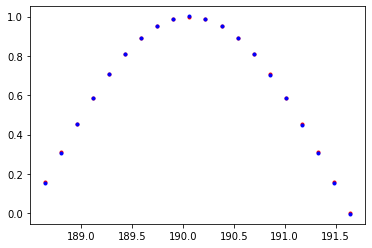

In [31]:
n_steps = 75
print_every = 15
trained_rnn = train(rnn, n_steps, print_every)